## Predict the futute returns of HDFCBANK

Data Source: [yfinanance](https://in.finance.yahoo.com/quote/HDFCBANK.NS/history/)

The historical stock quote for HDFC Bank is used for the analysis below. I have used the data from 2000-01-01 to 2020-10-27 for my analysis. The project showcases a machine learning algorithm to predict whether to Buy/Sell stocks.

In [188]:
# Import the libraries

import pandas as pd
import numpy as np
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import matplotlib.pyplot as plt


In [189]:
# Read the data (CSV downloaded from Yahoo Finance)

df = pd.read_csv("HDFCBANK.NS1.csv")
df.shape

(5213, 7)

In [190]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
5208,2020-10-20,1207.500000,1227.400024,1205.900024,1223.949951,1223.949951,13705989.0
5209,2020-10-21,1230.599976,1251.000000,1221.699951,1246.699951,1246.699951,17820376.0
5210,2020-10-22,1239.949951,1250.000000,1223.000000,1233.300049,1233.300049,10956530.0
5211,2020-10-23,1243.500000,1248.449951,1231.199951,1235.800049,1235.800049,7933115.0
5212,2020-10-26,1229.800049,1242.000000,1204.599976,1210.900024,1210.900024,9785988.0


In [191]:
df.isnull().sum()

Date          0
Open         69
High         69
Low          69
Close        69
Adj Close    69
Volume       69
dtype: int64

In [192]:
# Drop the rows with all missing values

df = df.dropna(thresh=6)
df.shape

(5144, 7)

In [193]:
# Setting the date as the index

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5144 entries, 2000-01-03 to 2020-10-26
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5144 non-null   float64
 1   High       5144 non-null   float64
 2   Low        5144 non-null   float64
 3   Close      5144 non-null   float64
 4   Adj Close  5144 non-null   float64
 5   Volume     5144 non-null   float64
dtypes: float64(6)
memory usage: 281.3 KB


### Target Variable

The target variable is a binary variable (1 for Buy and -1 for sell).
If the Open price on (t+1)th day is greater than the Open price on (t)th day, 
then the target variable for the (t)th day will be defined as Buy (1), else Sell (-1).

In [194]:
# Creating the target variable. 
df['BuyOrSell'] = df['Open'].diff().apply(lambda x: -1 if x>0 else 1)

In [195]:
# Distribution of the target variable
df['BuyOrSell'].value_counts()

-1    2600
 1    2544
Name: BuyOrSell, dtype: int64

### Creating Features

In [196]:
# 14 Days RSI

# Change for (t)th day is Close for (t)th day minus CLose for (t-1)th day.
df['Change'] = df['Close'].diff()

# Gain or Loss for the day
# If the change is positive, it is a Gain, else it is a Loss.
df['Gain'] = df['Change'].apply(lambda x: x if x > 0 else 0)
df['Loss'] = df['Change'].apply(lambda x: -x if x < 0 else 0)

# 14 Days Moving Average for Gain and Loss.
df['14DayAvgGain'] = df.rolling(14, min_periods=14)['Gain'].mean()
df['14DayAvgLoss'] = df.rolling(14, min_periods=14)['Loss'].mean()

# Claculating the Relative Strength
df['RS'] = df['14DayAvgGain']/df['14DayAvgLoss']

# 14 Days Relative Strength Index
df['14DayRSI'] = 100 - 100/(1+df['RS'])

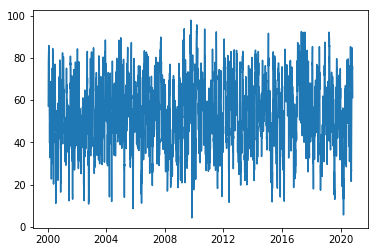

In [197]:
plt.plot(df['14DayRSI'])

From the above graph, we can see that there was no significant rise or fall in the stock market condition for a long time. Neither any level of overbought or oversold is seen as such.

In [198]:
# 14 Days Volatility

# Calculate Change percent
df['Change%'] = df['Change']/df['Close']*100

# 14 Days Volatility
df['14DayVolatility'] = df.rolling(14, min_periods=14)['Change%'].std()

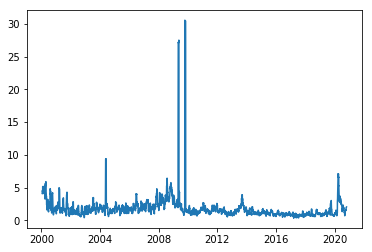

In [199]:
plt.plot(df['14DayVolatility'])

There are just a couple of spikes seen in the abobe chart, and rest of the time the indicator doesn't provide much information.

In [200]:
# Calculating Force Index

# Force Index for (t)th day
df['ForceIndex1'] = df['Change'] * df['Volume']

# 14 Day Weighted Exponential MA of the Force Index
df['ForceIndex13'] = df['ForceIndex1'].ewm(span=13,adjust=False).mean()

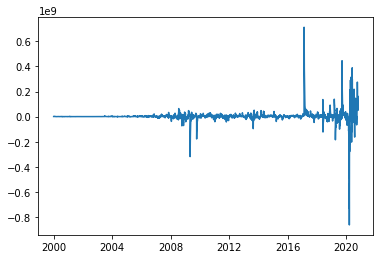

In [201]:
plt.plot(df['ForceIndex13'])

From the above chart we can see when the stock enters the positive zone (above zero) and when it enters the negative zone (below zero).

In [202]:
# Calculating difference between 'Open' and 'Close' of the previous day
df['Open-Close'] = df['Open'].shift(1) - df['Close'].shift(1)

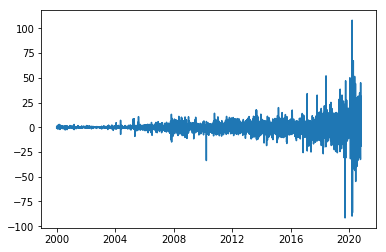

In [203]:
plt.plot(df['Open-Close'])

From the above chart we can see that there has been more fluctuations in the prices in the recent past as compared to the earlier years.

In [166]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume,BuyOrSell,Change,Gain,Loss,14DayAvgGain,14DayAvgLoss,RS,14DayRSI,Change%,14DayVolatility,ForceIndex1,ForceIndex13,Open-Close
Date,,,,,,,,,,,,,,,,,,,
2020-10-20,1207.500000,1227.400024,1205.900024,1223.949951,1223.949951,13705989.0,1,20.399902,20.399902,0.000000,17.053571,5.525007,3.086615,75.529872,1.666727,1.962872,2.796008e+08,1.226832e+08,31.449951
2020-10-21,1230.599976,1251.000000,1221.699951,1246.699951,1246.699951,17820376.0,-1,22.750000,22.750000,0.000000,17.532148,5.525007,3.173235,76.037777,1.824818,1.971527,4.054136e+08,1.630732e+08,-16.449951
2020-10-22,1239.949951,1250.000000,1223.000000,1233.300049,1233.300049,10956530.0,-1,-13.399902,0.000000,13.399902,15.507150,6.482143,2.392288,70.521367,-1.086508,1.991867,-1.468164e+08,1.188033e+08,-16.099975
2020-10-23,1243.500000,1248.449951,1231.199951,1235.800049,1235.800049,7933115.0,-1,2.500000,2.500000,0.000000,15.157148,6.482143,2.338293,70.044569,0.202298,1.997227,1.983279e+07,1.046646e+08,6.649902
2020-10-26,1229.800049,1242.000000,1204.599976,1210.900024,1210.900024,9785988.0,1,-24.900025,0.000000,24.900025,13.032148,8.260716,1.577605,61.204298,-2.056324,2.046724,-2.436713e+08,5.490236e+07,7.699951


In [167]:
# Since the moving average reuslted in NaN values for the initial rows, drop them.
# df = pd.DataFrame(df).fillna(0)

df = df.dropna()

In [168]:
df.shape

(5130, 19)

### Split the dataframe into train, val and test

I have used the data till March 2018 for training purpose, April 2018 to March 2019 for validation purpose and April 2019 onwards for testing purpose.

In [169]:
train = df['2000-01-03':'2018-03-31']
val  = df['2018-04-01':'2019-03-31']
test  = df['2019-04-01':]
train.shape, val.shape, test.shape

((4497, 19), (246, 19), (387, 19))

In [170]:
# Extracting the features and target variables

X_train = train.drop('BuyOrSell',1)
y_train = train['BuyOrSell']
X_val = val.drop('BuyOrSell',1)
y_val = val['BuyOrSell']
X_test = test.drop('BuyOrSell',1)
y_test = test['BuyOrSell']

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((4497, 18), (246, 18), (387, 18), (4497,), (246,), (387,))

### Model Selection

Since this is a classification problem, and requires a comprehensive analysis that would forsee the combination of all possible outcomes, I choose the Decision Tree model as it requires less effort to clean the data and is very easy to interpret.

In [171]:
# Training a Decision Tree Model with Gini as spliting criteria
clf_gini = DecisionTreeClassifier(criterion='gini')
clf_gini.fit(X_train,y_train)

# Prediction for validation data
y_val_pred = clf_gini.predict(X_val)

# Performance of Decision Tree Model with Gini as spliting criteria on the validation data
accuracy_gini = accuracy_score(y_val,y_val_pred)
f1_gini = f1_score(y_val,y_val_pred)
accuracy_gini, f1_gini

(0.8008130081300813, 0.7741935483870966)

In [172]:
# Prediction for test data
y_test_pred = clf_gini.predict(X_test)

# Performance of Decision Tree Model with Gini as spliting criteria on the test data
accuracy_gini = accuracy_score(y_test,y_test_pred)
f1_gini = f1_score(y_test,y_test_pred)
accuracy_gini, f1_gini

(0.7596899224806202, 0.7657430730478588)

In [173]:
# Training a Decision Tree Model with Entropy as spliting criteria
clf_entropy = DecisionTreeClassifier(criterion='entropy')
clf_entropy.fit(X_train,y_train)

# Prediction for validation data
y_val_pred = clf_entropy.predict(X_val)
# Performance of Decision Tree Model with Entropy as spliting criteria on the validation data
accuracy_entropy = accuracy_score(y_val,y_val_pred)
f1_entropy = f1_score(y_val,y_val_pred)
accuracy_entropy, f1_entropy

(0.8617886178861789, 0.8482142857142857)

In [174]:
# Prediction for test data
y_test_pred = clf_entropy.predict(X_test)

# Performance of Decision Tree Model with Entropy as spliting criteria on the test data
accuracy_entropy = accuracy_score(y_test,y_test_pred)
f1_entropy = f1_score(y_test,y_test_pred)
accuracy_entropy, f1_entropy

(0.8036175710594315, 0.8173076923076923)

In [175]:
# Random Forest Model
#model for tuning the min samples of leaf
clf_1 = RandomForestClassifier(min_samples_leaf=2, random_state=9)
clf_1.fit(X_train,y_train)

#model for tuning the max depth
clf_2 = RandomForestClassifier(max_depth = 5, random_state=9)
clf_2.fit(X_train,y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=9, verbose=0, warm_start=False)

In [176]:
# predicting for min_samples 0f leaf as 2.
y_clf_1 = clf_1.predict(X_val)

# predicting for max depth 5.
y_clf_2 = clf_2.predict(X_val)

# Performance on the validation data
accuracy_clf_1 = accuracy_score(y_val,y_clf_1)
accuracy_clf_2 = accuracy_score(y_val,y_clf_2)
f1_clf_1 = f1_score(y_val,y_clf_1)
f1_clf_2 = f1_score(y_val,y_clf_2)

accuracy_clf_1, f1_clf_1, accuracy_clf_2, f1_clf_2

(0.8780487804878049,
 0.8660714285714286,
 0.8780487804878049,
 0.8672566371681415)

In [177]:
# predicting for min_samples 0f leaf as 2.
y_clf_11 = clf_1.predict(X_test)

# predicting for max depth 5.
y_clf_21 = clf_2.predict(X_test)

# Performance on the test data
accuracy_clf_11 = accuracy_score(y_test,y_clf_11)
accuracy_clf_21 = accuracy_score(y_test,y_clf_21)
f1_clf_11 = f1_score(y_test,y_clf_11)
f1_clf_21 = f1_score(y_test,y_clf_21)

accuracy_clf_11, f1_clf_11, accuracy_clf_21, f1_clf_21

(0.8242894056847545, 0.84037558685446, 0.8320413436692506, 0.8463356973995272)

## Performance of the test data on the various models

##### Decision Tree with Gini as the spliting criteria
Accuracy, F1_score = 0.7596899224806202, 0.7657430730478588

##### Decision Tree with Entropy as the spliting criteria
Accuracy, F1_score = 0.8036175710594315, 0.8173076923076923
<br>On changing splitting criteria from Gini to Entropy, the accuray increased by 4% and F1 score by 5%. 

##### Random Forset for min_samples of leaf as 2
Accuracy, F1_score = 0.8242894056847545, 0.84037558685446
<br>On predicting the data using a random forest classifier, with minimum sample of leaf as 2, the accuracy further increased by 2% and F1 score by 2.3%.

##### Random Forset for max depth 5
Accuracy, F1_score = 0.8320413436692506, 0.8463356973995272
<br>On further tuning the hyper parameters of the Random Forest classifier, the accuracy increased by 1% and F1 score by 0.5%.

## Next Steps

* Detailed analysis of data, to check the underlying patterns before training the model.
* Explore more parameters to predict the change in the pattern.
* Train the model on more data, so that it is more robust.

Hybrid Algorithms can also be tested and different libraries can be explored to make more accurate predictions.
Further, since this is a time series data, different components effecting the trends can be studied and future predictions being made using algorithms like ARMA.